__Import Libraries and Datasets__

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from stldecompose import decompose
from pandas.plotting import register_matplotlib_converters
import datetime
from pandas.plotting import table

In [2]:
df = pd.read_csv('Mobile_Price.csv')
df=df[['Date','PriceValue','MobilePhone']]
df=df.set_index('Date')
df.index=pd.to_datetime(df.index)
df=df.sort_index()
df.head()

,PriceValue,MobilePhone
Date,,
2018-08-01,11635,Nokia_six
2018-08-01,55490,Samsung_Galaxy_S7Edge
2018-08-01,17005,Redmi_Note7_Pro
2018-08-01,26850,One_Plus_6T
2018-08-01,121720,Iphone_10X


The different types of phones are: 
{'Iphone_10X', 'Nokia_six', 'One_Plus_6T', 'Oppo_F1', 'Redmi_6A', 'Redmi_Note7_Pro', 'Samsung_Galaxy_S7Edge'}

Suppose the Mobile phone selected is Oppo F1 then the processing occur as shown below:-


In [3]:
df_mobile=df[df.MobilePhone=='Oppo_F1'] # User input #1
df_mobile=df_mobile[['PriceValue']]
df_mobile.head()

,PriceValue
Date,
2018-08-01 00:00:00.000000000,8950
2018-08-06 23:08:34.285714285,9450
2018-08-12 22:17:08.571428571,9050
2018-08-18 21:25:42.857142857,8950
2018-08-24 20:34:17.142857142,9650


__NOTE__ :Instead of hardcoding the name of mobile phone it can taken as an input from user.

__Identifying the trend__: Every mobile phone price follow a trend that is influenced by the sales that happen every year during same point of time. Some examples are like the New Year Sale, Black Friday Sale, Christmas Sale and several other celebratory occasions. These sales have an impact on the mobile prices and this impact is proportional to the market value of the phone.

In [4]:
out=decompose(df_mobile['PriceValue'])

The actual mobile price and the general shift in the prices are shown in the graph. We can observe that there is a time when the price drops below the usual value and this insight can be provided to the user so that he can achieve his goals in an effective manner.

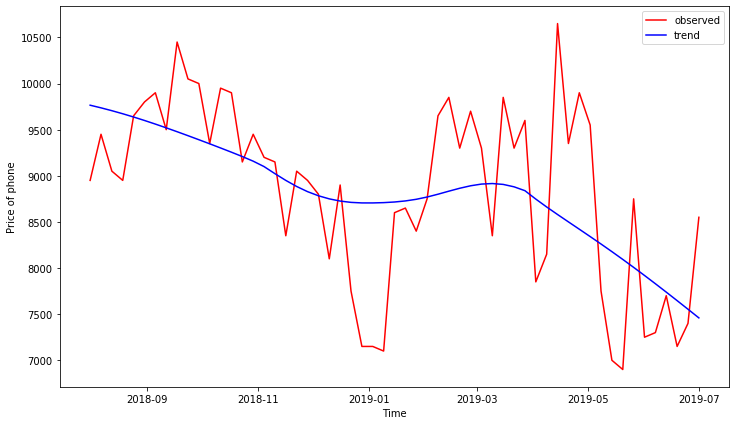

In [5]:
register_matplotlib_converters()
plt.figure(figsize=(12,7))
plt.plot(df_mobile.index,out.observed,c='red',label='observed')
plt.plot(df_mobile.index,out.trend,c='blue',label='trend')
plt.xlabel('Time')
plt.ylabel('Price of phone')
plt.legend()

Suppose the user wants to buy the phone in 6 months from now then the logic will check when the price of the phone will be lowest in the next three months and whats the price at the end of three months. Number of months can be taken as an input from the user.

In [6]:
no_months=6 #user input #2
last_date=(datetime.date.today()+datetime.timedelta(no_months*365/12) - datetime.timedelta(365)).isoformat()

The trend of the mobile price is checked and then the minimum available price along with the price with at the time of last date is found out.

In [7]:
same_price=0
minimum_price_date=out.trend[:last_date].idxmin(axis=0)
minimum_price=out.trend[:last_date].min()
last_date_price=out.trend[:last_date][-1]
print("Minimum price = ", minimum_price," & Minimum price date = ",minimum_price_date.date())
if minimum_price!=last_date_price:
    print("Last date price = ",last_date_price, " & Last date = ", last_date)
else:
    same_price=1

Minimum price =  8705.673978195666  & Minimum price date =  2019-01-03
Last date price =  8745.125157356093  & Last date =  2019-01-29


The user is asked for the current price of the mobile phone and then by method of interpolation logic the price for this mobile is calculated and then reported

In [8]:
new_price=15000 #user input #3
interest_point=(datetime.date.today()-datetime.timedelta(365)).isoformat()
old_price=out.trend[interest_point:][0]
#minimum
expected_diff1 = (old_price-minimum_price)*new_price/old_price
expected_price_min=new_price - expected_diff1
print("Expected minimum price = ",expected_price_min)
#last date
expected_diff2 = (old_price-last_date_price)*new_price/old_price
expected_price_last=new_price - expected_diff2
print("Expected price on last day = ",expected_price_last)

Expected minimum price =  13372.641241170848
Expected price on last day =  13433.241542396796


__CutOff determination__

Reading dataset and Analyzing the spendings of customer and possible areas of cutoff.

In [9]:
df=pd.read_csv('Customer_Transactions.csv',parse_dates=['Date'])
df=df[['Date','Type','Amount','Parent Category']].drop_duplicates()
df_credit=df[df.Type=='Credit']
df_debit=df[df.Type=='Debit']
df_credit_sum=df_credit.drop(['Type','Parent Category'],axis=1).set_index('Date')
df_debit=df_debit.drop(['Type'],axis=1)

__Analysis__ : The data is analyzed on monthly scale for both the income and the expenditure.


Income per month of the customer

In [10]:
df_in=df_credit_sum.resample('M').sum()
df_in

,Amount
Date,
2018-06-30,28980
2018-07-31,18180
2018-08-31,13260
2018-09-30,1260
2018-10-31,3240


Expenditure per month of the customer

In [11]:
df_debit=df_debit.pivot(index='Date', columns='Parent Category', values='Amount')
df_debit.fillna(0)
df_debit=df_debit.resample('M').sum()
df_out=df_debit.sum(axis=1)
df_out

Date
2018-06-30    19800.0
2018-07-31    12600.0
2018-08-31     8500.0
2018-09-30     1710.0
2018-10-31     2510.0
Freq: M, dtype: float64

Average savings per month of the customer

In [12]:
income=df_in.reset_index(drop=True).Amount
exp=df_out.reset_index(drop=True)
df_savings=income-exp
per_month_savings=df_savings.sum()/len(df_savings)
per_month_savings

3960.0

In [13]:
no_months=6 #user input #2
minimum_price=30000#minimum_price or last_date_price
total_savings=per_month_savings*no_months
needed_saving=minimum_price-total_savings
per_month_cutoff=needed_saving/no_months

Cutoff the user should save from every sector in each month so that he has the remaining money apart from the regular savings that he has.

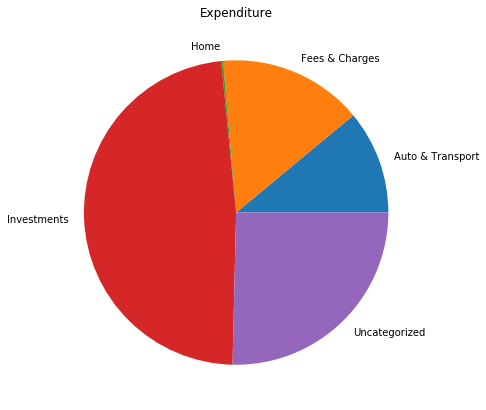

In [14]:
per_sector_exp=df_debit.sum(axis=0)
per_sector_rexp=per_sector_exp/per_sector_exp.sum()
ax=per_sector_exp.rename(' ').plot.pie(figsize=(7,7),title="Expenditure")
ax.figure.savefig('distribution_chart.jpg')
per_month_per_sector=per_sector_rexp*per_month_cutoff
#per_month_per_sector

The amount of savings in each sector in each month is calculated.

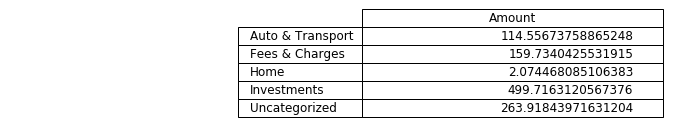

In [15]:
fig, ax = plt.subplots(figsize=(12, 2)) # set size frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
ax.set_frame_on(False)  # no visible frame, uncomment if size is ok
tabla = table(ax, per_month_per_sector.rename('Amount'), loc='upper right', colWidths=[0.3]*len(per_month_per_sector))  # where df is your data frame
tabla.auto_set_font_size(False) # Activate set fontsize manually
tabla.set_fontsize(12) # if ++fontsize is necessary ++colWidths
tabla.scale(1.5, 1.5) # change size table
plt.savefig('table.png', transparent=True)


Analysis on investment made by the person and a comparision of hte same to the return he is getting from those investment.

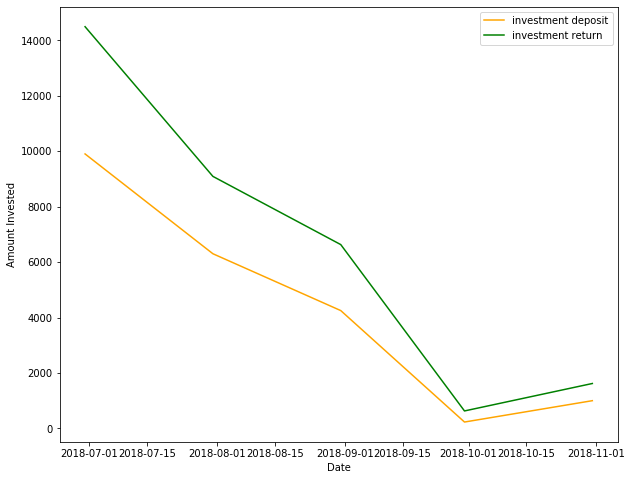

In [16]:
df_invest=df[df['Parent Category']=='Investments']
df_invest_in=df_invest[df_invest['Type']=='Credit']
df_invest_out=df_invest[df_invest['Type']=='Debit']
df_invest_in=df_invest_in.drop(['Type','Parent Category'],axis=1).set_index('Date')
df_invest_out= df_invest_out.drop(['Type','Parent Category'],axis=1).set_index('Date')
df_invest_in =df_invest_in.resample('M').sum()
df_invest_out=df_invest_out.resample('M').sum()
plt.figure(figsize=(10,8))
plt.plot(df_invest_out,c='orange',label='investment deposit')
plt.plot(df_invest_in,c='green',label='investment return')
plt.xlabel('Date')
plt.ylabel('Amount Invested')
plt.legend()
plt.savefig('Investment_charts.png')